# Deploy Keras Model to the Cloud
1. Download data
2. Hot Encode Categorical Columns
3. Develop Model (use: ```RMSprop(lr=, rho=, epsilon=, decay=)```)
3. Create Storage Bucket (should already exist)
4. Authenticate on Google Cloud Platform
5. Deploy your model using the ```gcloud``` tool

In [1]:
# !conda install imbalanced-learn -y # Is used to oversample minority class to balance the class distribution
# As of 08 July 2023, the package `imbalanced-learn` doesn't seem to be working with scikit-learn >= 1.3
# Downgrade scikit-learn to scikit-learn = 1.2 if needed

In [2]:
# Verify package versions
# !conda list scikit-learn
# !conda list imbalanced-learn

## 1. Download Data

### Download

In [3]:
# !wget https://storage.googleapis.com/nicksdemobucket/bank.csv # This dataset cannot be found
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2023-07-08 20:02:14--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [  <=>               ] 999.85K  3.51MB/s    in 0.3s    

2023-07-08 20:02:14 (3.51 MB/s) - ‘bank+marketing.zip’ saved [1023843]



In [4]:
# The data is in a nested zip file. Let's unzip it

import zipfile
from pathlib import Path

# Iterate over the files in the nested ZIP folder
for file_path in Path.cwd().glob('**/*.zip'):
    print('Unzipping...')
    # Open the nested ZIP file
    with zipfile.ZipFile(file_path, 'r') as nested_zip_ref:
        # Extract all contents of the nested ZIP file
        nested_zip_ref.extractall(Path(Path.cwd(), 'bank_data'))


Unzipping...
Unzipping...
Unzipping...


### About the Dataset

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).


Below, I use `bank-full.csv`.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


### Variables

#### Input variables

**Bank client data**
   
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")
                                       
3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

**Related with the last contact of the current campaign**

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

**Other attributes**

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")


#### Output variable (desired target)
17 - y - has the client subscribed a term deposit? (binary: "yes","no")


### Load

In [5]:
import numpy as np
import pandas as pd

df = pd.read_csv(Path(Path.cwd(), 'bank_data', 'bank-full.csv'), sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## 2. Hot Encode Categorical Columns

### Encode Target

In [8]:
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
df['y'] = df['y'].astype('bool')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,False
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,False
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,False
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,False
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,False


### Encode Predictors

In [9]:
# Get all categorical columns
categorical_cols = df.select_dtypes(include='object').columns
print(categorical_cols)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')


In [10]:
# Hot encode all categorical columns; the first column for each categorical varialbe is dropped
df_onehot = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_onehot.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,False,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,False,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,False,0,1,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,False,1,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,False,0,0,...,0,0,0,1,0,0,0,0,0,1


In [11]:
df_onehot.dtypes

age                    int64
balance                int64
day                    int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                       bool
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_married        uint8
marital_single         uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
default_yes            uint8
housing_yes            uint8
loan_yes               uint8
contact_telephone      uint8
contact_unknown        uint8
month_aug              uint8
month_dec              uint8
month_feb              uint8
month_jan              uint8
month_jul              uint8
month_jun     

## EDA

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

### Target Class Balance/Imbalance

In [13]:
# The number of records for each target category and descriptive statistics for `age`
df_onehot.groupby('y')['age'].describe()


,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
False,39922.0,40.838986,10.172662,18.0,33.0,39.0,48.0,95.0
True,5289.0,41.670070,13.497781,18.0,31.0,38.0,50.0,95.0


In [14]:
ratio_y_counts = 39922 / 5289
ratio_y_counts

7.548118737001324

There are ~7.5 times more clients who didn't subscribe a term deposit (y=False) than those who did (y=True). This means we are dealing with highly imbalanced class distribution. To mitigate issues related to class imbalance, I will use oversampling technique to balance the class distribution.


### Distribution of Predictors

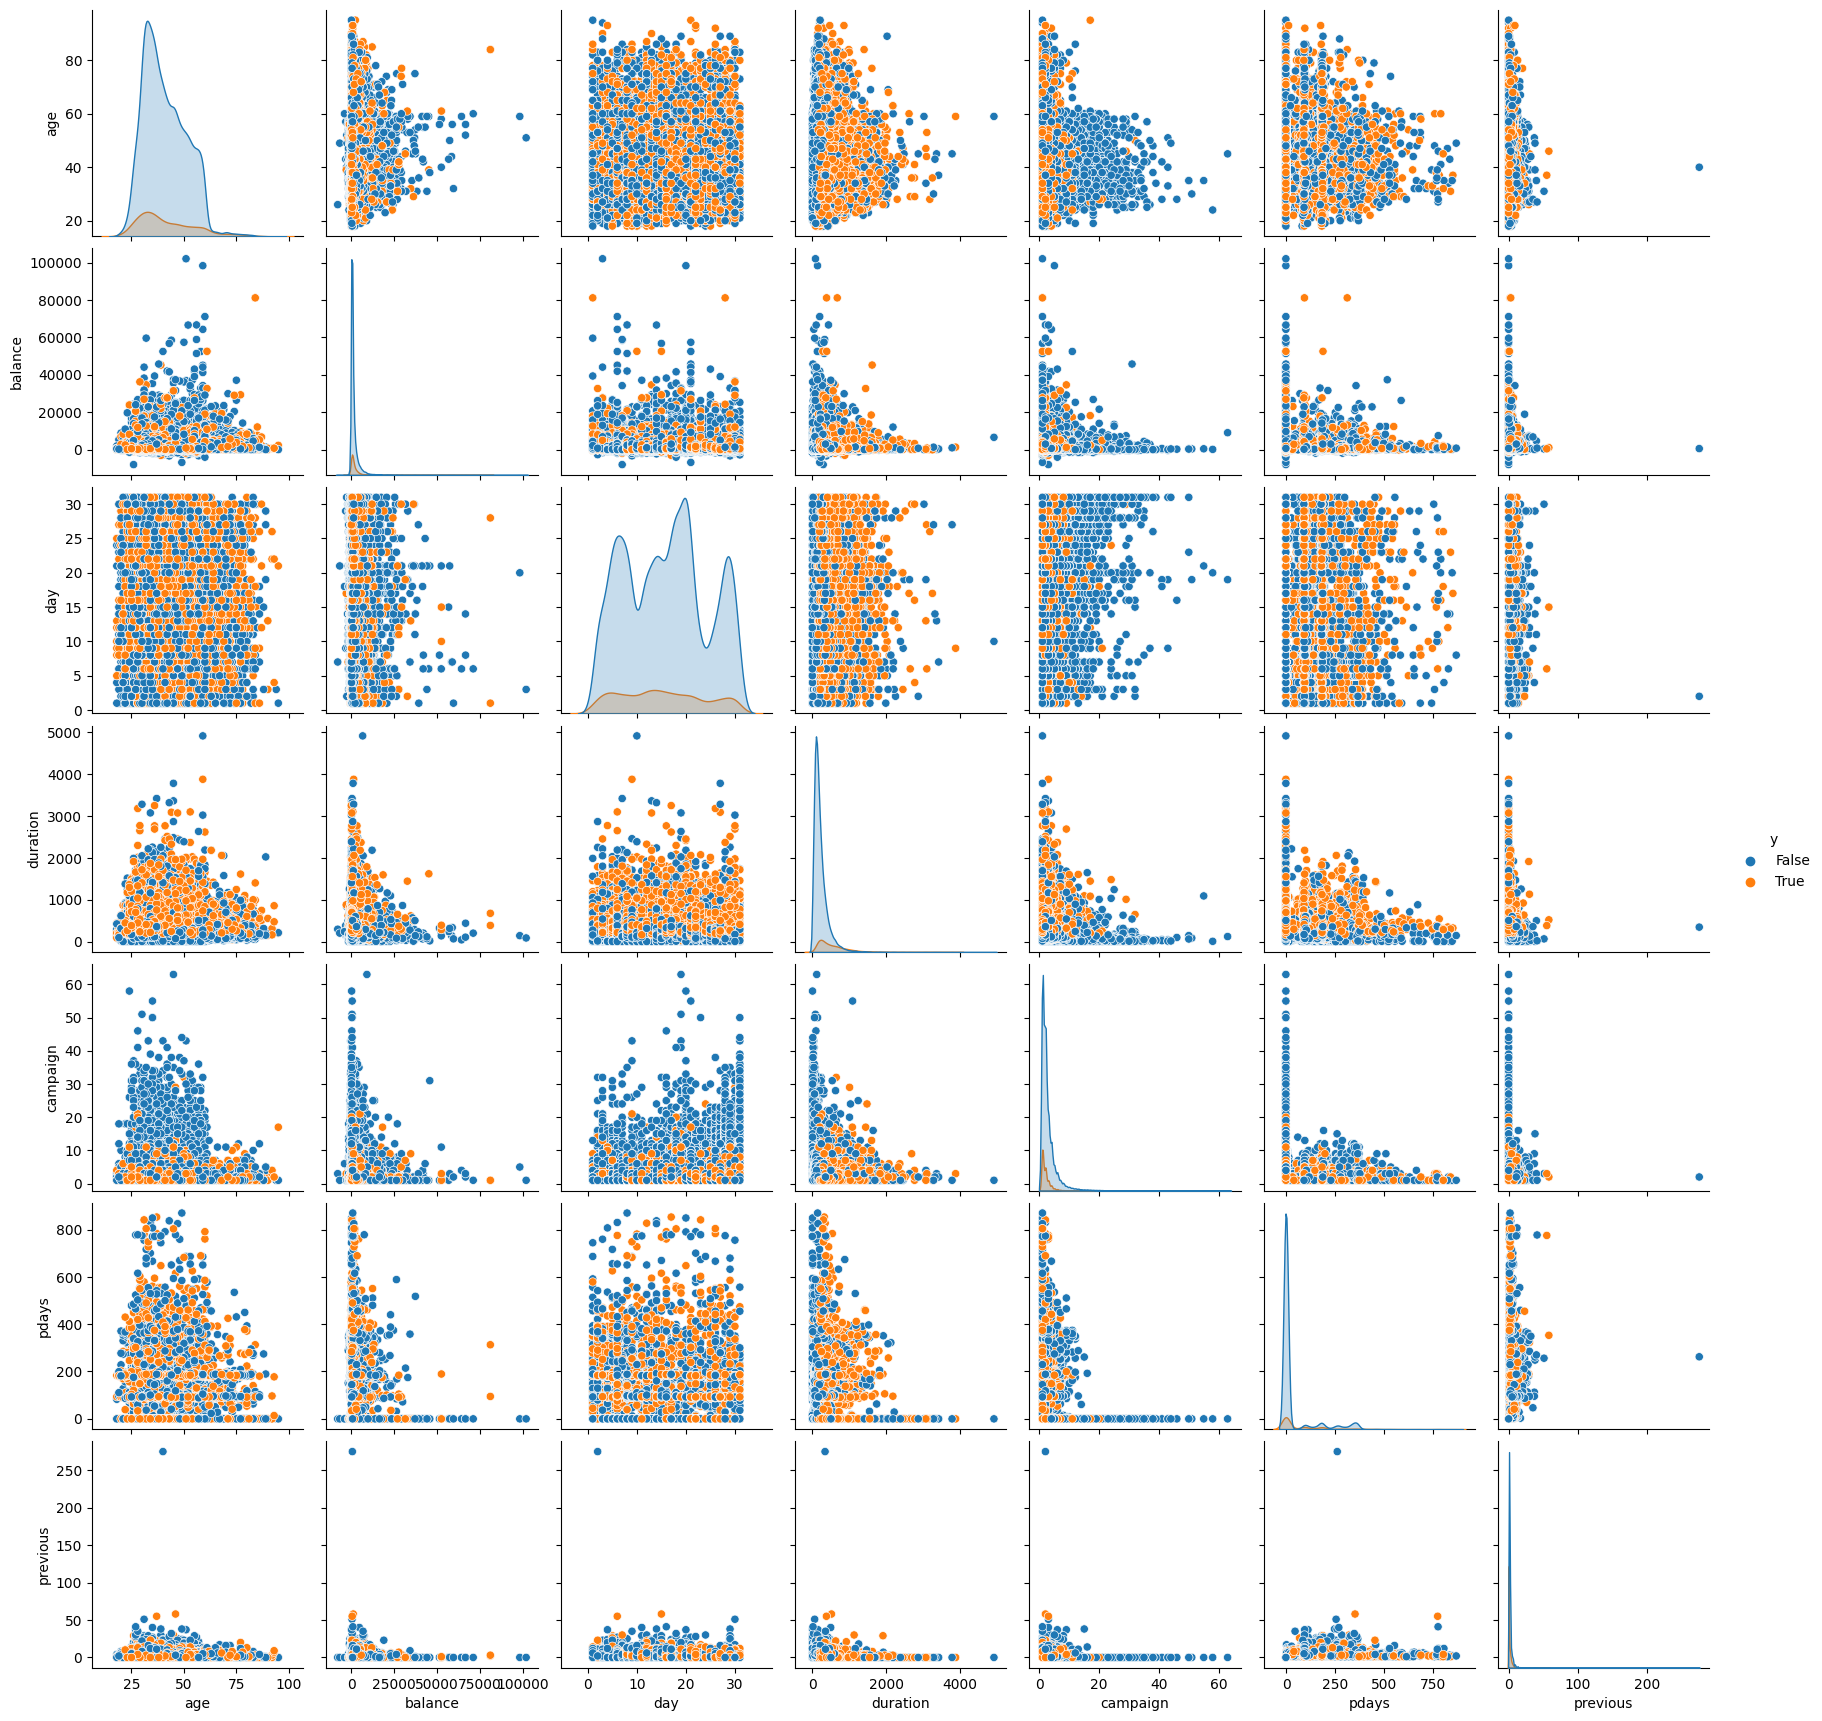

In [15]:
# Get integer columns
int_cols = df_onehot.select_dtypes('int').columns

# Plot the data
sns.pairplot(df_onehot[list(int_cols) + ['y']], hue='y')
plt.show()

There is one record with extreme value for the number of contacts performed before this campaign (`previous`). Let's remove this record and plot the data, again.

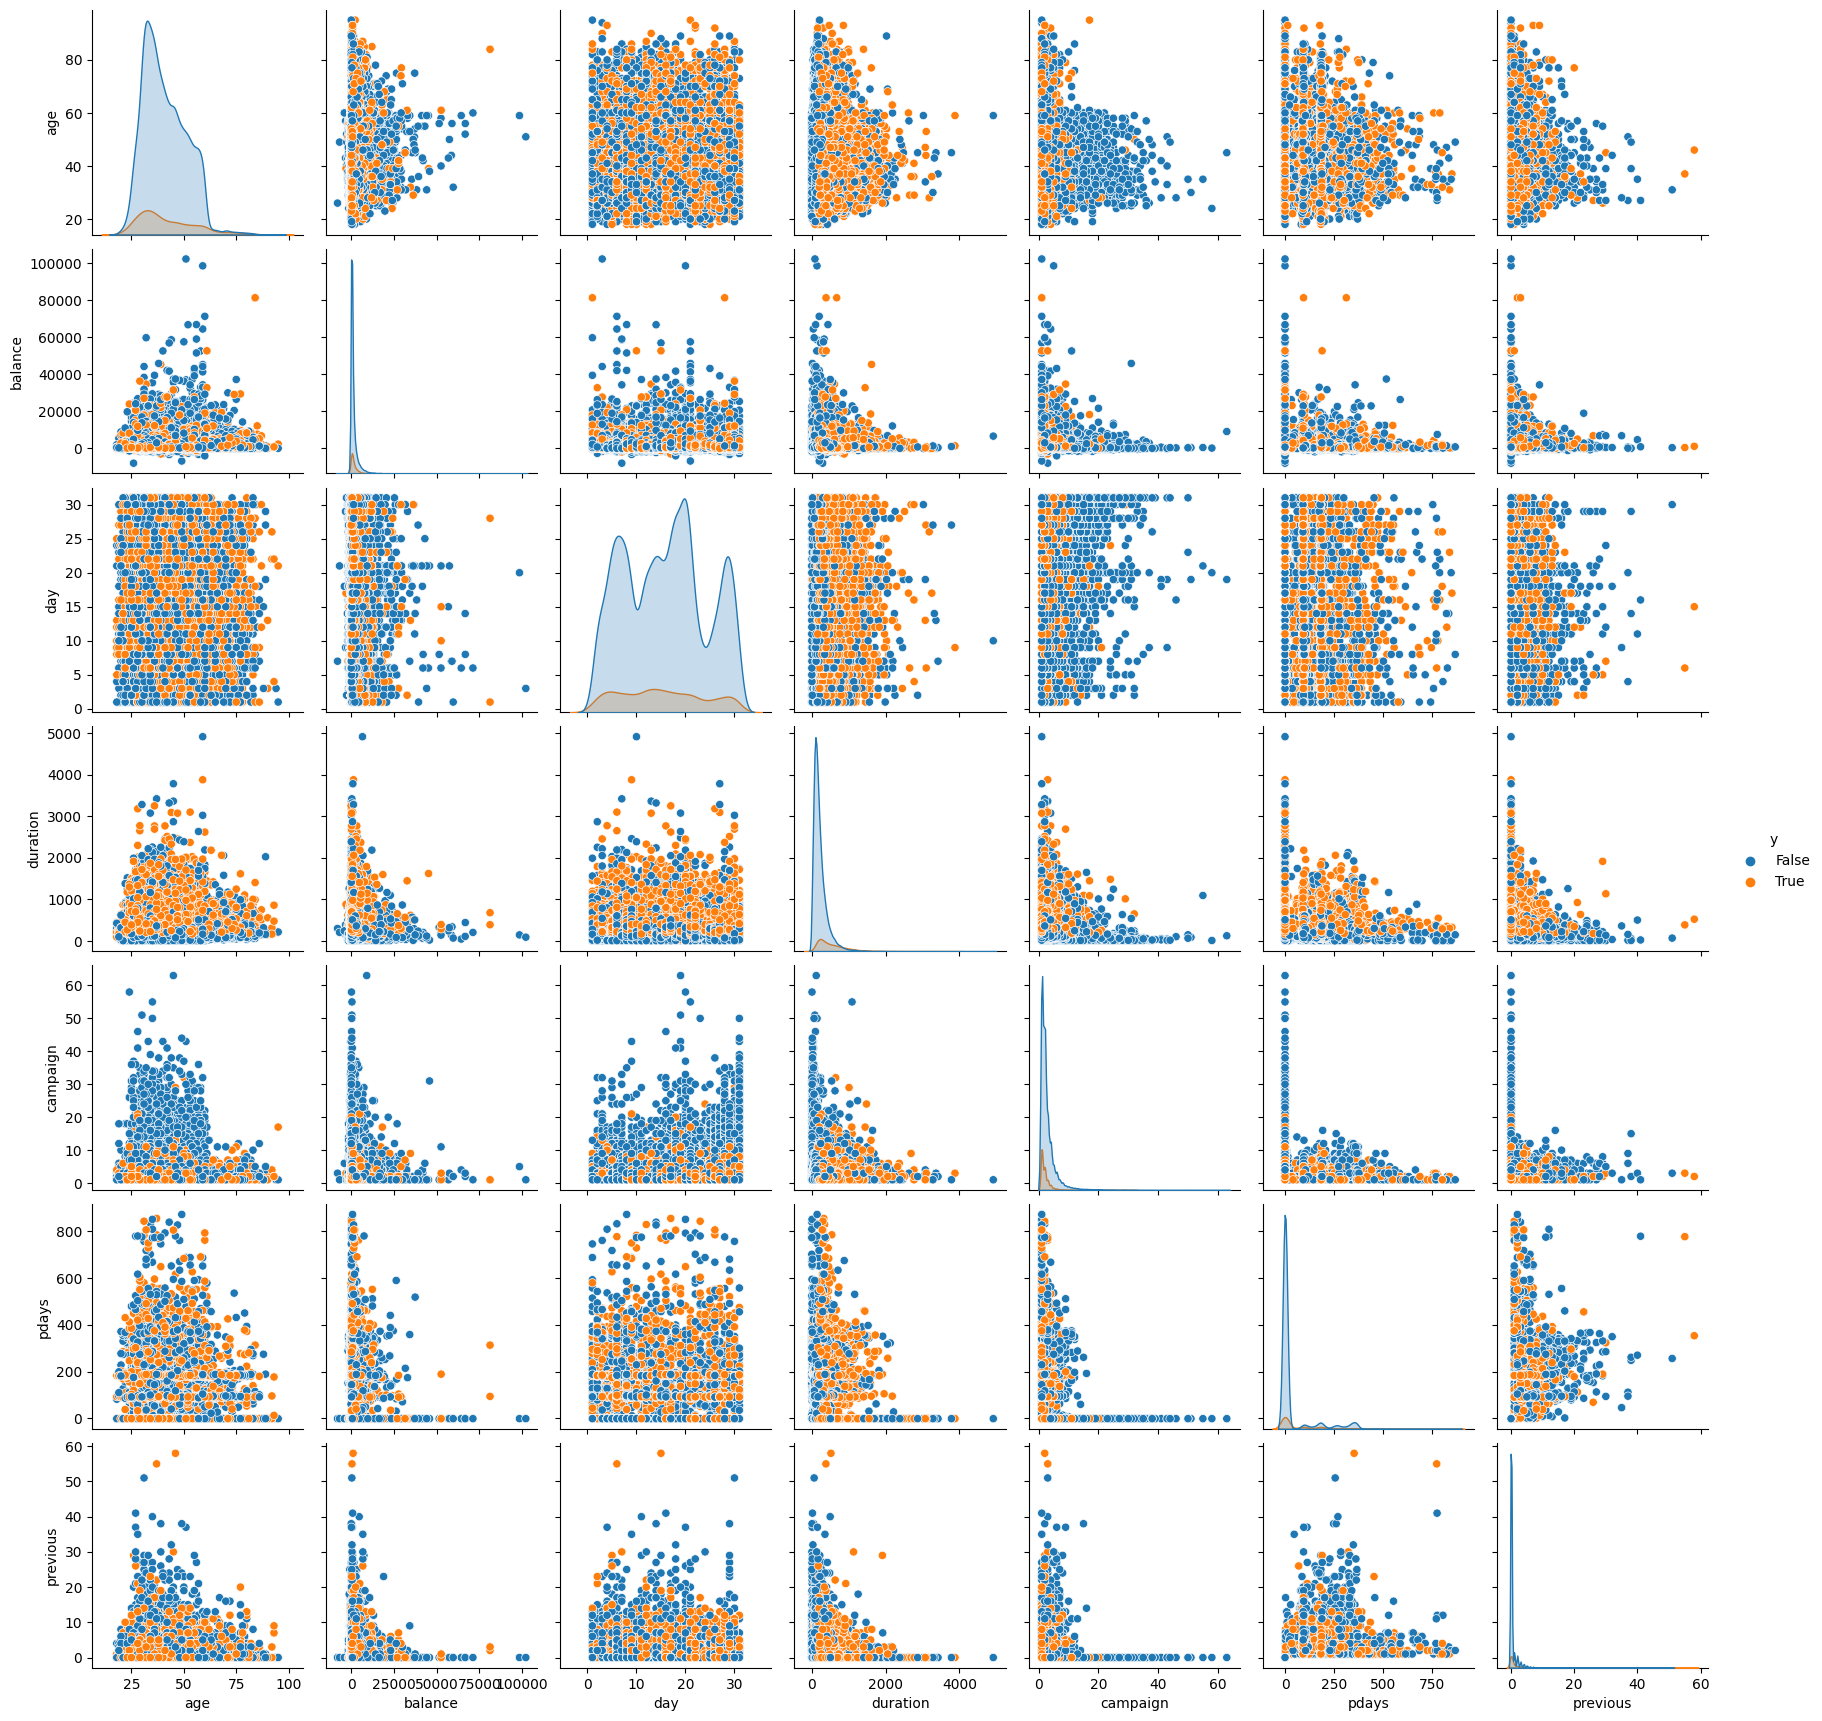

In [16]:
# Remove the record with the extreme value
df_onehot = df_onehot[df_onehot['previous'] < df_onehot['previous'].max()]

# Plot
sns.pairplot(df_onehot[list(int_cols) + ['y']], hue='y')
plt.show()

## Prepare the Data

### Split into Training and Test Sets

In [17]:
# Predictors and target variable
y = df_onehot[['y']].astype('int')
X = df_onehot.drop('y', axis=1).astype('int')

print("The shape of the target variable:", y.shape)
print("The shape of the predictors", X.shape)

The shape of the target variable: (45210, 1)
The shape of the predictors (45210, 42)


In [18]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale

To preserve the distribution of the data, I will use a `MinMaxScaler` to transform numerical variables. It will help minimize biases and facilitate convergence of the model.

In [19]:
from sklearn.preprocessing import MinMaxScaler

int_cols = X.select_dtypes('int').columns
scaler = MinMaxScaler()

# Fit and transform predictors of the training set
X_train[int_cols] = scaler.fit_transform(X_train[int_cols])
X_train = X_train.values

# Transform predictors of the test set
X_test[int_cols] = scaler.transform(X_test[int_cols])
X_test = X_test.values


### Resample Training Set to Balance Class Distribution

In [20]:
from imblearn.over_sampling import RandomOverSampler

X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(X_train, y_train)
np.unique(y_train_resampled, return_counts=True)

(array([0, 1]), array([31972, 31972]))

In [21]:
X_train_resampled.shape

(63944, 42)

In [22]:
y_train_resampled = np.reshape(y_train_resampled, (-1, 1))
y_train_resampled.shape

(63944, 1)

## 3. Develop the Model
(use: `RMSprop(lr=, rho=, epsilon=, decay=)`)

### Create the Model

In [23]:
import tensorflow as tf
from tensorflow import keras

# Set seed
seed = 42
tf.random.set_seed(42)

# Define the model
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(y_train_resampled.shape[1], activation='sigmoid'))

# Define the optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08) # `decay` is depricated in the new Keras optimizer

# Compile the model
model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2752      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,977
Trainable params: 6,977
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [24]:
# Train the model

class Callback_10(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1} - Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f}")

fit_history = model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=100, batch_size=32, verbose=0, callbacks=[Callback_10()])


Epoch 1 - Loss: 0.4187 - Accuracy: 0.8077
Epoch 10 - Loss: 0.2914 - Accuracy: 0.8770
Epoch 20 - Loss: 0.2667 - Accuracy: 0.8903
Epoch 30 - Loss: 0.2525 - Accuracy: 0.8974
Epoch 40 - Loss: 0.2448 - Accuracy: 0.9035
Epoch 50 - Loss: 0.2406 - Accuracy: 0.9058
Epoch 60 - Loss: 0.2363 - Accuracy: 0.9084
Epoch 70 - Loss: 0.2313 - Accuracy: 0.9113
Epoch 80 - Loss: 0.2276 - Accuracy: 0.9138
Epoch 90 - Loss: 0.2233 - Accuracy: 0.9158
Epoch 100 - Loss: 0.2242 - Accuracy: 0.9160


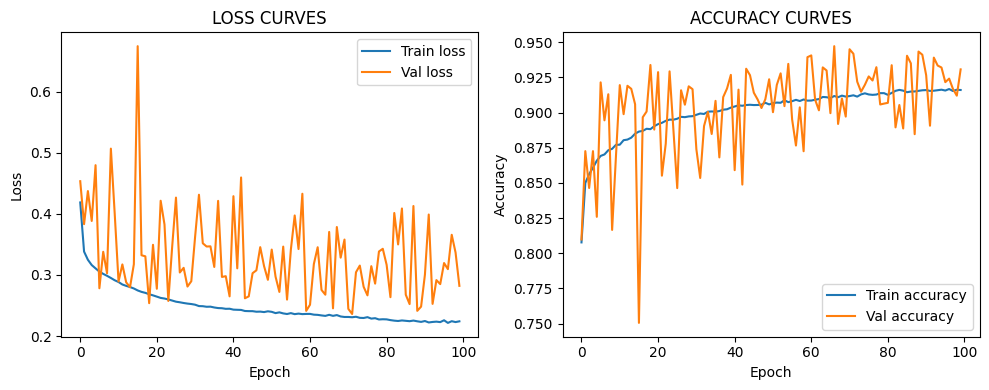

In [25]:
# Plot performance matrics curves

import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(fit_history.history['loss'], label='Train loss')
axes[0].plot(fit_history.history['val_loss'], label = 'Val loss')
axes[0].legend()
axes[0].set(title='Loss Curves'.upper(), xlabel='Epoch', ylabel='Loss')

axes[1].plot(fit_history.history['accuracy'], label='Train accuracy')
axes[1].plot(fit_history.history['val_accuracy'], label='Val accuracy')
axes[1].legend()
axes[1].set(title='Accuracy Curves'.upper(), xlabel='Epoch', ylabel='Accuracy')

plt.tight_layout()

plt.show()


### Save the Model


In [27]:
keras_model_path = Path(Path.cwd(), 'keras_model')
model.save(keras_model_path)

## 4. Create a Storage Bucket
(should already exist)


1. Create an account on Google Cloud Platform (GCP)
2. Create a new project
3. Create a backet (storage backets are under the Cloud Storage tab)

In [152]:
PROJECT_ID = "mcgill-dsml-pml-homework-m08" #@param {type:"string"}
BUCKET_NAME = "mcgill-dsml-pml-homework-m08-backet" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"}

## 5. Authenticate on Google Cloud Platform

In [153]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


In [154]:
# Verify the access to the project
!gcloud config set project $PROJECT_ID
!echo $PROJECT_ID

Updated property [core/project].
mcgill-dsml-pml-homework-m08


## 6. Deploy the Model
(use the `gcloud` tool)

### Store the Model on GCP

In [155]:
# Load the locally saved model
model_load = keras.models.load_model(keras_model_path)

In [156]:
# List the existing backets on GCP
! gsutil ls -al

In [157]:
# Create a bucket
! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME

Creating gs://mcgill-dsml-pml-homework-m08-backet/...


In [158]:
# Create a directory within the bucket to store the model
JOB_DIR = 'gs://' + BUCKET_NAME + '/bank_term_deposit_predictor'

# Export the model to GCP
model_load.save(JOB_DIR +'/keras_export')

In [159]:
# Display the content of the backet
print(f"The backet '{BUCKET_NAME}' contains the following:")
!gsutil ls -al gs://$BUCKET_NAME

The backet 'mcgill-dsml-pml-homework-m08-backet' contains the following:
                                 gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/


### Create a Serving Model on GCP

In [160]:
MODEL_NAME = "bank_term_deposit_model"
MODEL_VERSION = "v1"

In [167]:
# Create a model
! gcloud ai-platform models create bank_term_deposit_model
! gcloud config set ai_platform/region us-central1


Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/mcgill-dsml-pml-homework-m08/models/bank_term_deposit_model].
Updated property [ai_platform/region].


In [168]:
# Create a version of the model; if the model already existis version.name ERROR will occur

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/
print("!gsutil ls $JOB_DIR/keras_export/ \n")
print(KERAS_EXPORT_DIRS)
print("-" * 3)
# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[0]
print("Saved_model_path:")
print(SAVED_MODEL_PATH)
print("-" * 3)

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 2.2 \
  --python-version 3.7 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH


!gsutil ls $JOB_DIR/keras_export/ 

['gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/', 'gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/fingerprint.pb', 'gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/keras_metadata.pb', 'gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/saved_model.pb', 'gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/assets/', 'gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/variables/']
---
Saved_model_path:
gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/
---
Using endpoint [https://us-central1-ml.googleapis.com/]


### Test the Model

#### Predict for a single record

In [169]:
# Get the first record from the test set
i_record = 0
print(X_test[i_record].tolist())

[0.28571428571428575, 0.07806910827447207, 0.5, 0.03904026026840179, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [170]:
# Convert the data to a json file
%%bash

# if already found ! first Delete
rm prediction_input.json
touch prediction_input.json
echo "[0.28571428571428575, 0.07806910827447207, 0.5, 0.03904026026840179, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]" >> prediction_input.json
cat prediction_input.json


[0.28571428571428575, 0.07806910827447207, 0.5, 0.03904026026840179, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [171]:
!ls

bank_data  bank+marketing.zip  keras_model  prediction_input.json  sample_data


In [172]:
# Deploy the model; the output is the probability that the output is 1, i.e., a prediction that the client subscribes a term deposit.
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

Using endpoint [https://us-central1-ml.googleapis.com/]
[[4.21850749e-12]]


In [173]:
# The actual output value
print("The actuval target value:", y_test.values[i_record])


The actuval target value: [0]


#### Predict for multiple records

I couldn't make the function work.

Is it possible that the access to the model using `service` object is not enabled?

Or maybe, there is a mistake in the address of the http request? In the request above the endpoint is https://us-central1-ml.googleapis.com/ but here the request is sent to  https://ml.googleapis.com/...

In [184]:
from googleapiclient.discovery import build

def predict_json(project, model, instances, version=None):

  service = build("ml", "v1")
  name = 'projects/{}/models/{}'.format(project, model)

  if version is not None:
      name += '/versions/{}'.format(version)

  response = service.projects().predict(
      name=name,
      body={'instances': instances}
  ).execute()

  if 'error' in response:
      raise RuntimeError(response['error'])

  return response['predictions']


test_predictions = predict_json(PROJECT_ID, MODEL_NAME, X_test[0].tolist())

HttpError: ignored

## Delete the Serving Model from GCP


In [185]:
# Delete model !
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL_NAME

! gcloud ai-platform models delete $MODEL_NAME --quiet

! gsutil rm -r gs://$BUCKET_NAME

Using endpoint [https://us-central1-ml.googleapis.com/]
Using endpoint [https://us-central1-ml.googleapis.com/]
Removing gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/#1688858747115135...
Removing gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/#1688858747612186...
Removing gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/assets/#1688858752510303...
Removing gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/fingerprint.pb#1688858753313607...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://mcgill-dsml-pml-homework-m08-backet/bank_term_deposit_predictor/keras_export/keras_me